#1. **Импорт библиотек**   
1.   Для работы с базой данных используется Pandas.
2.   Для работы с графами, используемыми для построения пути развития навыков,  используется библиотека NetworkX




In [2]:
#установка networkx в случае необходимости
!pip install networkx

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import itertools

In [4]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.ticker
from graphviz import Digraph
from IPython.display import Image
warnings.filterwarnings('ignore')

Монтирование диск google drive

In [5]:
#подключение google drive
drive.mount('/content/drive')

#переход в папку с файлами
%cd "/content/drive/My Drive/ProjectN5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ProjectN5


#2. Импорт данных из БД

Для работы системы рекомендации курсов необходимо загрузить данные об идеальных вакансиях, построенных на основе анализа рынка вакансий, базу курсов и данные клиента.  
Формирование идеальной вакансии происходит из объединения данных вакансий, полученных из анализа рынка труда, мнения экспертов и оценивания востребованности навыков


In [6]:
#функция загрузки вакансий, содержащие все возможные требуемые навыки
#на данный момент адреса хранения вакансий жестко заданы
#и ограничены только одной специальностью UX/UI дизайнер
def LoadVacMarket(files_adresses = 'None'):
    
    vacs = []
    
    df_intern = pd.read_csv('./database/стажер.csv').drop(['Unnamed: 0', 'percent', 'frequency'], axis = 1)      #'intern' (стажер)
    vacs.append(df_intern)

    df_junior = pd.read_csv('./database/junior.csv').drop(['Unnamed: 0', 'percent', 'frequency'], axis = 1)      #'junior'
    vacs.append(df_junior)

    df_middle = pd.read_csv('./database/middle.csv').drop(['Unnamed: 0', 'percent', 'frequency'], axis = 1)      #'middle'
    vacs.append(df_middle)

    df_middle_p = pd.read_csv('./database/middle+.csv').drop(['Unnamed: 0', 'percent', 'frequency'], axis = 1)   #'middle+
    vacs.append(df_middle_p)

    df_senior = pd.read_csv('./database/senior.csv').drop(['Unnamed: 0', 'percent', 'frequency'], axis = 1)      #'senior'
    vacs.append(df_senior)

    df_lead = pd.read_csv('./database/lead.csv').drop(['Unnamed: 0', 'percent', 'frequency'], axis = 1)          #'lead'  
    vacs.append(df_lead)

    return vacs

In [7]:
#функция объединения датасетов в соответствии с уровнями в системе оценок уровня клиента
# 'intern' и 'junior' ->'junior;  'middle' и ''middle+ -> middle
#(временная опция)
def VacanciesJoin(vacs):
    
    vacsNew = []

    #объединение датасетов в соответствии с системой оценивания
    df_jun = pd.concat([vacs[0], vacs[1]]).groupby(['skills']).sum().sort_values(by = 'sum', ascending = False)
    vacsNew.append(df_jun)

    df_mid = pd.concat([vacs[2], vacs[3]]).groupby(['skills']).sum().sort_values(by = 'sum', ascending = False)
    vacsNew.append(df_mid)

    vacsNew.append(vacs[4])
    vacsNew.append(vacs[5])

    return vacsNew

In [8]:
#функция загрузки БД курсов
def DBCoursesLoad(db_adress = 'None'):

    all_coursesDB = pd.read_csv('./database/courses_model_test.csv')

    return all_coursesDB

In [9]:
#загрузка данных клиента 
#загружается список файлов для более удобного тестирования работы модели
def ClientLoad(filename):
    
    for filename in filenames:
        client = pd.read_csv(filename)
  
    return client

In [37]:
#список тестовых клиентских данных
filenames = ['./clients/almost_lead.csv']
filename2 = ['./clients/newcome_to_2.csv']

#3. Подготовка данных
На основании данных клиента, вакансий, построенной на основании анализа рынка и данных экспертов строится база данных, курсов, которые можно предложить клиенту и его профиль соответствия требуемой вакансии и позиции (jun, middle и т.д.)

Уровни владения навыком (*expert_values*) задаются экспертами. На данный момент уровень владения навыками единый на позицию (junior, middle и т.д.): (a) **0 - нет навыка**; (b) **1 - junior**; (c) **2 - middle**; (d) **3 - senior**; (e) **4 - lead**.    
Уровень отсечки (*thresholds*) задает порог встречаемости навыка в вакансии. При частоте встречаемости навыка ниже задваемого порога, навык считается малозначимым и отсекается. На основании отсчеки наывков формируется Core skill build (набор ключевых навыков).

In [11]:
#данные по порогу отсечки навыка и уровень владения навыками
thresholds_levels = [0.03, 0.03, 0.03, 0.03]
expert_levels = [1, 2, 3, 4]

In [12]:
#названия файлов с идеальной вакансией
csv_names  = ['junior_ideal','middle_ideal', 'senior_ideal', 'lead_ideal']

In [13]:
#расчет идеального скилсета в соответствии с порогом
def VacIdSkillSet(vacs_list, thresholds, expert_values):

  ideal_list = []
  
  #расчет частоты навыков в цикле
  for i, dfs in enumerate(vacs_list):
    df_curr = pd.DataFrame()
    df_curr = dfs
    
    #расчет процентов производится, т.к. из-за объединения датасетов 'intern' и 'junior', 'middle' и 'middle+' необходимо заново рассчитать проценты
    df_curr_S = df_curr['sum'].sum()
    df_curr['frequency'] = pd.Series(['{:.4f}'.format(x / df_curr_S) for x in df_curr['sum']], index = df_curr.index).astype(float)
    df_curr['percent'] = pd.Series(['{:.2%}'.format(x) for x in df_curr['frequency']], index = df_curr.index)

    #исключение навыков, частота которых в вакансиях меньше заданной
    df_curr = df_curr.loc[df_curr.loc[:,'frequency'] >= thresholds[i]]
    df_curr.loc[:,'expert'] = expert_values[i]

    df_curr = df_curr.drop(['sum'], axis = 1)
    ideal_list.append(df_curr)
    
    del df_curr

  return ideal_list

In [14]:
#загрузка данных идеальных вакансий на диск
def VacIdDownload(ideal_list, csv_names, filenames = 'None'):

    for i, ideal_vac in enumerate(ideal_list):
        filename = './vac_temp/{}.csv'.format(csv_names[i])
        ideal_list[i].to_csv(filename)

    return True

In [15]:
#загрузка данных идеальных вакансий с диска
def VacIdUpload(filenames):

    ideal_list = []
    
    for i, filename in enumerate(filenames):
        ideal_list[i] = pd.read_csv(filename)

    return ideal_list

In [16]:
#формирование входного скилсета
def SkillSetsDiff(initial, ideal_list, desired_level):
#initial - входный лист с даными клиентов

    #создание датасета
    ideal_ = ideal_list[desired_level - 1].copy(deep = True)
    ideal_ = ideal_.reset_index()

    length = initial.shape[0]
    output = pd.DataFrame(np.zeros((length, 4)), index = initial.index, columns = ['skills', 'client', 'expert', 'level_difference'])


    output['skills'] = initial['skills']
    output['client'] = initial['client']
    output['expert'] = ideal_['expert']
  
    #расчет разности между уровнями владения навыком
    output['level_difference'] = initial['client'] - ideal_['expert']

    return output

In [17]:
#выборка курсов на основе разности между уровнями владения навыком (клиента и идеальной вакансии)
def CoursesList(level_diff, courses_database):

    courses = []

    for i in range(level_diff.shape[0]):
        if level_diff.loc[i,'level_difference'] < 0:
            skill = level_diff.loc[i,'skills']
            courses.append(skill)
  
    courses_full = pd.Series(courses)
    df1 = courses_database[courses_database['skill_in_vacancies'].isin(courses_full)]
    
    return df1

#4. Рекомендации курсов на основе построения графа развития

Рекомендации выдаются как для одного курса, так и для пути развития, включающего курсы, предназначенные для повышения различных навыков. 
На рисунке представлен пример графа для навыка - Adobe Photoshop (APS). Граф является направленным (directed), и связан соотношением между начальным (уровень поступающих, *in*) и конечным (уровень выпускников, *out*) уровнем владения навыка.

Найдя все простуые пути на графе, можно определеить все возможные пути освоения навыка. Каждый узел содержит информацию о курсе, например:  


*   цена курса (*price*)
*   продолжительность курса (*duration_months*)
*   число часов в неделю, требуемое на обучение (*intensity*)
*   приоритет обучения при прокачке навыков (*priority*)
*   тип курса (онлайн, оффлайн)
*   время и расписание занятий
*   связь курса с курсами по другим навыкам (дизайн->веб-дизайн)
и т.д.

На данный момент анализирует только: *price*, *duration_months*, *intensity*,
*priority*. 

NB! В данной версии программы, рассматриваются только "непрерывные" графы, т.е. графы у которого нет разрыва между уровнями курсов, например (1->2->4), графы же типа (1->2, 3->4) не рассматриваются. 




* 



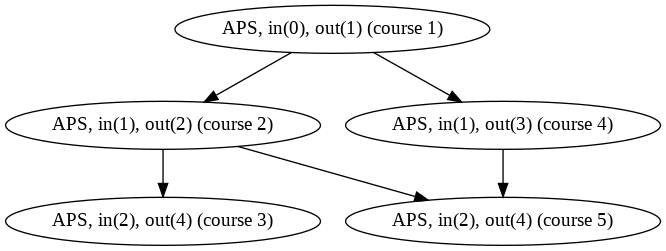

In [18]:
Image(filename="./figures/simple graph.png")

In [19]:
#расчет начального (уровень поступающих) и конечного (уровень выпускников) уровня курса
def InFinQual(skill, data_courses):
  
    quals = []

    current = data_courses.query('skill_in_vacancies == @skill')
    quals.append(int(current['qualification'].min()))
    quals.append(int(current['qualification_up'].max()))
    #print(quals)

    return quals

In [20]:
#построение графа курсов для навыка
def SkillGraph(skill, all_courses, client):


    #функция получает все возможные курсы для соискателя, и начальный уровень клиента
    #выделяет из них один скилл, который передается как параметр
    #и на его основе строит граф и предлагает выбор курсов
    #создание направленного графа
    G = nx.DiGraph()
  
    data = all_courses.query('skill_in_vacancies == @skill').reset_index()
    qs = InFinQual(skill, all_courses)

    #лист для хранения вторичный узлов
    initial_nodes = []
    final_nodes = []
  
    #задание начальной и конечной квалификаций
    initial_qualification = int(client.loc[client.loc[:,'skills'] == skill, 'client'].item())
    final_qualification = int(client.loc[client.loc[:,'skills'] == skill, 'expert'].item())
  
    #установление начальной и конечной квалификаций
    if qs[0] > initial_qualification:
        initial_qualification = qs[0]   
    if qs[1] < final_qualification:
        final_qualification = qs[1]
    
    for i in range(data.shape[0]):
        #создание списка начальных узлов
        if data.loc[i, 'qualification'] == initial_qualification:
            G.add_node(data.loc[i,'course'])
            initial_nodes.append(data.loc[i,'course'])

        #конечные узлы
        if data.loc[i, 'qualification_up'] == final_qualification:
            final_nodes.append(data.loc[i,'course'])

        for j in range(0, data.shape[0]):
            if (data.loc[i, 'qualification_up'] == data.loc[j, 'qualification']) and i != j:
                G.add_node(data.loc[j,'course'])
                G.add_edge(data.loc[i,'course'], data.loc[j,'course'])

    return data, G, initial_nodes, final_nodes

In [21]:
#нахождение всех простых путей в графе
def FindPaths(graph, initial_nodes, final_nodes):
     
    paths = []

    for init_node in initial_nodes:
        for final_node in final_nodes:
            path = nx.all_simple_paths(graph, source = init_node, target=final_node)
            paths.append(list(path))

    return paths    

In [22]:
#функция для расчета критерия вдоль пути
def ValueAlongPath(path, criterion, data, threshold):
      
    S = 0 #суммарная цена
    D = 0 #суммарная длительность
    intensity_list = []

    #суммарная стоимость курсов
    if criterion == 'money':
        for node in path:
            price = int(data.loc[data.loc[:,'course'] == node, 'price'].item())
            S = S + price
        S = int(S)
        return S

    #суммарная длительность курсов    
    if criterion == 'duration':
        for node in path:
            duration = int(data.loc[data.loc[:,'course'] == node, 'duration_months'].item())
            D = D + duration
        D = int(D)
        return D

    #интенсивность курсов
    if criterion == 'intensity':
        for node in path:
            intensity = int(data.loc[data.loc[:,'course'] == node, 'hours_weekly'].item())
            intensity_list.append(intensity)
        if all(x <= threshold for x in intensity_list):
            return int(threshold)
        else:
            return int(threshold + 1)

In [23]:
#функция отбора набора курсов на основе расчет критерия
def BestPaths(paths_full, сriterion, threshold, data):
    
    recommended_paths = []  
    path_data = []

    for path in paths_full:
        for sub_path in path:
            path_value = ValueAlongPath(sub_path, сriterion, data, threshold)
            
            #отбор путей соответствующих критерию
            if path_value <= threshold:
                recommended_paths.append(sub_path)
                path_data.append(path_value)

    return recommended_paths, path_data

In [24]:
#построение направленного графа на основе пути
def RecomendPathGraph(paths):
    
    graph = nx.DiGraph()

    for i, path in enumerate(paths):
          for i in range(len(path)):
              if i <= len(path) - 2:
                  graph.add_edge(path[i], path[i+1])

    return graph

In [25]:
#функция расчета характрестик вдоль всех путей в графе
def AllPathsValue(paths_full, сriterion, data, threshold):
    
    path_data = []
    fullpath_value = []

    for path in paths_full:
        for sub_path in path:
            #расчет характристики курса вдоль пути
            path_value = ValueAlongPath(sub_path, сriterion, data, threshold)
            fullpath_value.append(path_value)
            path_data.append(sub_path) 

    return fullpath_value, path_data

In [26]:
#функция для выделения курсов
def FullRecomend(client, courses, vacs_ideal, level, criterion, threshold):
    
    courses_paths = []
    courses_data = []
   
    #извлечение информации о небходимом скиллсете
    needed_skills = SkillSetsDiff(client, vacs_ideal, level)
    needed_courses = CoursesList(needed_skills, courses)  
    needed_skillset = needed_courses['skill_in_vacancies'].unique().tolist()

    #нахождение суммарной величины одной из характеритиск курсов, для всех возможных путей развития
    for skill in needed_skillset:
        df_data, g, init, final = SkillGraph(skill, courses, client)
        paths = FindPaths(g, init, final)
        full_p, p_data = AllPathsValue(paths, criterion, needed_courses, threshold)
    
        courses_paths.append(p_data)
        courses_data.append(full_p)

    return courses_paths, courses_data

In [27]:
#суммирование данных (цены, длительности) курсов для нахождения суммарной строимости курсов для двух навыков
def PairWiseSum(list1, list2, plist1, plist2, threshold, flat_flag):
       
    sum_list = []
    path_list = []
    subpath_list = []
    S = 0

    #суммирование данных для всех возможных путей развития одного навыка с
    #со всеми возможными путями развития другого навыка 
    for i in range(len(list1)):
        j = 0
        while j < len(list2):
            S = S + list1[i] + list2[j]
            #запись курсов соответствующих критерию
            if S <= threshold:            #проверка, что суммарная величина (например, стоимость), не превышает пороговую
                sum_list.append(S) 
                subpath_list.append(plist1[i])
        
                #запись списков когда ко списку содержащего подсписки присоединяется простой список
                if flat_flag == False:
                    subpath_list.append(plist2[j])
                else:
                    subpath_list[len(subpath_list) - 1].insert(len(subpath_list) - 1, plist2[j])
        
                path_list.append(subpath_list)
        
                subpath_list = []

            S = 0
            j += 1
    
    return sum_list, path_list

In [28]:
#уплощение листа
def FlattenList(input):
      
    flat_list = [item for sublist in input for item in sublist]

    return flat_list

In [29]:
#отсечка курсов, которые не удовляетворяют критериям пользователя
def SkillSetCut(courses_paths, courses_data, threshold):
      
    recommended_paths = []  
    path_list = []
    path_data = []
    flat_flag = False
    S = 0

    sum_list = courses_data[0]
    path_list = courses_paths[0]
    for i in range(len(courses_paths) - 1):
        list1 = sum_list
        list2 = courses_data[i + 1]
        plist1 = path_list
        plist2 = courses_paths[i + 1]
    
        sum_list, path_list = PairWiseSum(list1, list2, plist1, plist2, threshold, flat_flag)
        flat_flag = True
    
    return sum_list, path_list

In [30]:
#извлечение саб-листа
def ExtractLevel(list_):
    return list(itertools.chain(*list_))

In [31]:
#определение наиболее приоритетного курса из списка
def BestCourse(courses_list, client_courses):

    priority_list = []

    for course_name in courses_list:
        if course_name == 'None':
            priority_list.append(-1)
        else:
            priority_list.append(client_courses.loc[client_courses.loc[:,'course'] == course_name, 'priority'].item())

        max_priority = max(priority_list)
        max_index = priority_list.index(max_priority)

    return courses_list[max_index], max_index

In [32]:
def SkillPath(rec_paths, client_courses):
    
    skill_path = []

    #вспомогательные списки
    curr_path = []
    add_path = [] 
  
    for path_ in rec_paths:
        path = ExtractLevel(path_)
        inds = [0] * len(path)
        flags = [True] * len(path)
        add_path = [None] * len(path)
        path_flag = False
        curr_path = []
   
        while path_flag != True:
            for i, course_path in enumerate(path):
                if (flags[i] == True) and (inds[i] < len(course_path)):
                    flags[i] = False
                    add_path[i] = course_path[inds[i]]
                if inds[i] >= len(course_path):
                    add_path[i] = 'None'

      
            #поиск самого приоритетного курса
            first_course, course_ind = BestCourse(add_path, client_courses)  #возвращает самый приоритетный курс
     
            #добавление самого приоритетного из оставшихся курсов в путь развития
            if first_course != 'None':
                curr_path.append(first_course)
          
            inds[course_ind] += 1
            flags[course_ind] = True

            if all(courses == 'None' for courses in add_path):
               path_flag = True

        skill_path.append(curr_path)

    return skill_path

In [73]:
#создание БД со всем необходимыми курсами
def BuiltPathDB(skill_path, courses_database):

    all_pathsDB = []
    indices = []
    id = 1
    
    for i, path in enumerate(skill_path):
        path_list = []
        df1 = pd.DataFrame()

        for j, course in enumerate(path):
            #выделение необходимых курсов
            df1 = df1.append(courses_database[courses_database['course'] == course])
        
        df1 = df1.drop(['skill_in_vacancies'], axis = 1).reset_index(drop = True)
        all_pathsDB.append(df1)
        del df1

    return all_pathsDB

In [60]:
#расчет характеристик пути
def FinalOutput(client1, vacs_ideal, courses_db, level, threshold, criterion):
    
    skill_df = []

    client1_diff = SkillSetsDiff(client1, vacs_ideal, level)  #расчет разностей уровней
    client_courses = CoursesList(client1_diff, courses_db)  #выделение необходимых курсов
    courses_paths, courses_data = FullRecomend(client1_diff, courses_db, vacs_ideal, level, criterion, 12)
    sum_list, path_list = SkillSetCut(courses_paths, courses_data, threshold)
    skill_path = SkillPath(path_list, client_courses)
    all_pathsDB = BuiltPathDB(skill_path, courses_db)

    return all_pathsDB, skill_path

#5. Построение рекомендации

In [38]:
#загрузка данных
vacs = LoadVacMarket() #загрузка данных исходя из рынка
vacsN = VacanciesJoin(vacs) #объединение уровней в соответствии с критериями оценки
courses_db = DBCoursesLoad() #загрузка базы данных курса
client1 = ClientLoad(filenames) #загрузка данных клиента
vacs_ideal = VacIdSkillSet(vacsN, thresholds_levels, expert_levels) #построение иделаьного скиллсета
flag = VacIdDownload(vacs_ideal, csv_names) #загрузка на диск иделаьных вакансий

Пример постоения графа курса на основании клиентских данных (для курсов по Adobe Photoshop)

In [39]:
client1_diff = SkillSetsDiff(client1, vacs_ideal, 4)  #расчет разностей уровней
client_courses = CoursesList(client1_diff, courses_db)
a, g, init, final = SkillGraph('adobe photoshop', client_courses, client1_diff)
paths = FindPaths(g, init, final)

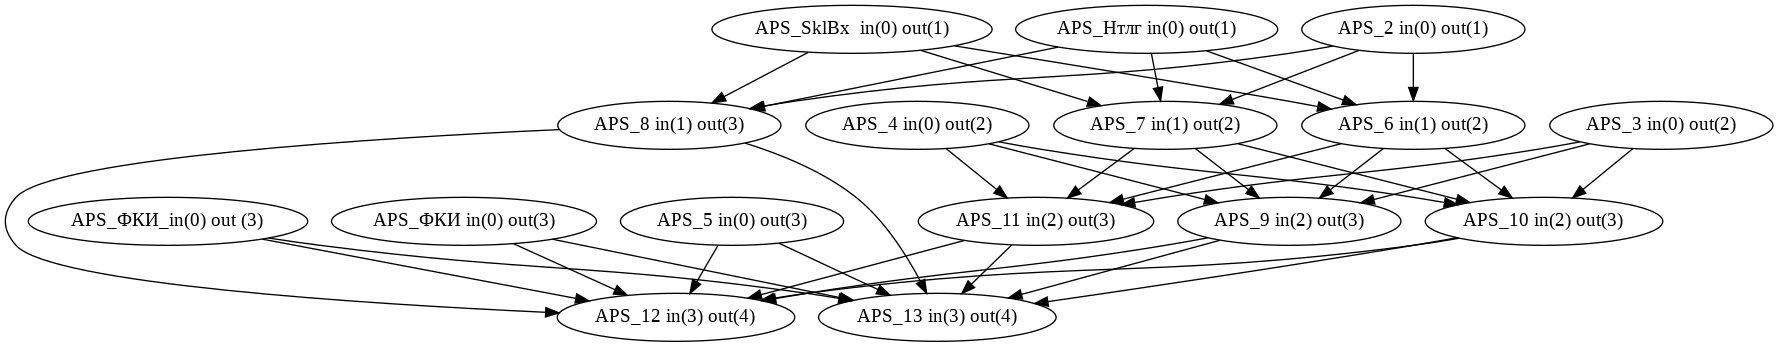

In [40]:
d = nx.drawing.nx_pydot.to_pydot(g)
png_str = d.create_png()
Image(data=png_str)

In [41]:
#отбор курсов по длительности
rec_paths, rec_data = BestPaths(paths, 'duration', 16, client_courses)
for i, path in enumerate(rec_paths):
    print('Суммарная длительность (мес.)', rec_data[i])
    print('courses path', path)
    print()
# print(path_duration)
# print(duration)

Суммарная длительность (мес.) 16
courses path ['APS_Нтлг in(0) out(1)', 'APS_7 in(1) out(2)', 'APS_10 in(2) out(3)', 'APS_12 in(3) out(4)']

Суммарная длительность (мес.) 16
courses path ['APS_3 in(0) out(2)', 'APS_10 in(2) out(3)', 'APS_12 in(3) out(4)']

Суммарная длительность (мес.) 16
courses path ['APS_4 in(0) out(2)', 'APS_9 in(2) out(3)', 'APS_12 in(3) out(4)']

Суммарная длительность (мес.) 14
courses path ['APS_4 in(0) out(2)', 'APS_10 in(2) out(3)', 'APS_12 in(3) out(4)']

Суммарная длительность (мес.) 15
courses path ['APS_4 in(0) out(2)', 'APS_11 in(2) out(3)', 'APS_12 in(3) out(4)']



Пример графа для курса по Adobe Photoshop (APS), курсы отобраны так, чтобы суммарная длительность прохождения курсов не превышала 16 месяцев.

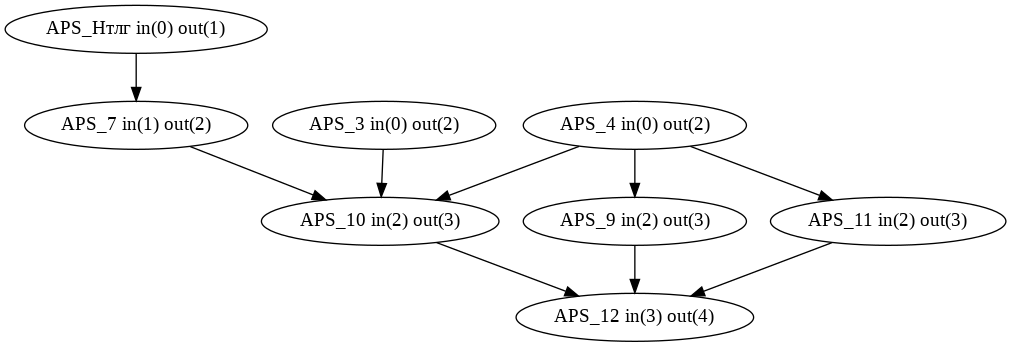

In [42]:
g = RecomendPathGraph(rec_paths)
d3 = nx.drawing.nx_pydot.to_pydot(g)
png_str3 = d3.create_png()
Image(data=png_str3)

In [79]:
coursesDB, skill_path = FinalOutput(client1, vacs_ideal, courses_db, 4, 1700000, 'money')

In [80]:
a = BuiltPathDB(skill_path, courses_db)

Пример набора курсов для одного из путей прокачки навыков. Все возможные пути хранятся в виде списка датафреймов. Вcе курсы в датафрейме для выбранного пути развития упорядочены по приоритету. 
Ниже приведен пример одного из набора путей прокачки навыков.


In [81]:
coursesDB[0]

,skill,qualification,course,link,hours,hours_weekly,duration_months,price,qualification_up,priority,expert_validation
0,Adobe Photoshop,0,APS_ФКИ_in(0) out (3),https://gb.ru/geek_university/commercial-illus...,80.0,9,12,110000,3.0,3,"0,15"
1,Проектирование пользовательских интерфейсов,0,Use interface design,NaN,250.0,8,6,150000,2.0,2,30%
2,Проектирование пользовательских интерфейсов,2,Проектирование2,NaN,250.0,8,6,300000,4.0,2,NaN
3,Adobe Photoshop,3,APS_12 in(3) out(4),NaN,243.0,9,6,750000,4.0,1,NaN
4,Agile Project Management,0,Agile 1,NaN,72.0,8,1,60000,1.0,1,NaN
5,Agile Project Management,1,Agile2,NaN,250.0,8,6,300000,3.0,3,NaN


In [ ]:
client1_diff = SkillSetsDiff(client1, vacs_ideal, 4)  #расчет разностей уровней
client_courses = CoursesList(client1_diff, courses_db)
a, g, init, final = SkillGraph('adobe photoshop', client_courses, client1_diff)
paths = FindPaths(g, init, final)

In [76]:
coursesDB, skill_path = FinalOutput(client1, vacs_ideal, courses_db, 4, 1700000, 'money')

In [77]:
coursesDB[1]

,skill,qualification,course,link,hours,hours_weekly,duration_months,price,qualification_up,priority,expert_validation
0,Adobe Photoshop,0,APS_ФКИ_in(0) out (3),https://gb.ru/geek_university/commercial-illus...,80.0,9,12,110000,3.0,3,"0,15"
1,Проектирование пользовательских интерфейсов,0,Use interface design,NaN,250.0,8,6,150000,2.0,2,30%
2,Проектирование пользовательских интерфейсов,2,Проектирование2,NaN,250.0,8,6,300000,4.0,2,NaN
3,Adobe Photoshop,3,APS_12 in(3) out(4),NaN,243.0,9,6,750000,4.0,1,NaN
4,Agile Project Management,0,Что такое управление проектами по методике agile,https://www.atlassian.com/ru/agile/project-man...,216.0,12,4,100000,2.0,1,10%
5,Agile Project Management,2,Agile_test,NaN,250.0,8,6,200000,3.0,3,NaN
